# 13. CNN with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 13.1 Prepare MNIST Data

In [3]:
train_data = dsets.MNIST(root='data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

test_data = dsets.MNIST(root='data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

In [4]:
batch_size = 100

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)

In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

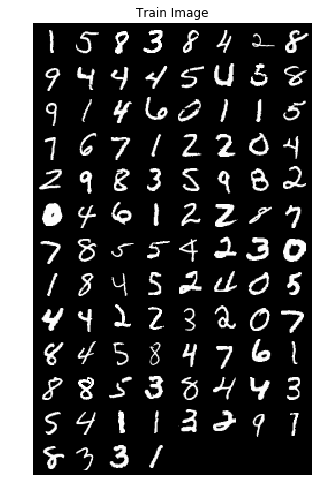

In [6]:
images, labels = iter(train_loader).next()
imshow(images, "Train Image")

In [7]:
images.shape, labels[0:5]

(torch.Size([100, 1, 28, 28]), tensor([1, 5, 8, 3, 8]))

## 13.2 Define Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

In [9]:
model = CNN().cuda()

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 13.3 Train Model

In [11]:
num_epochs = 3

In [12]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/3], lter [300/600], Loss: 2.2379
Epoch [1/3], lter [600/600], Loss: 0.5243
Epoch [2/3], lter [300/600], Loss: 0.2772
Epoch [2/3], lter [600/600], Loss: 0.3711
Epoch [3/3], lter [300/600], Loss: 0.1755
Epoch [3/3], lter [600/600], Loss: 0.1753


## 13.4 Test Model

In [13]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 95.890000 %
